<a href="https://colab.research.google.com/github/HugoMatousek/DL-BnW-to-color/blob/main/LABcolorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Follow these steps to connect to Kaggle (source of datasets). You will have to have an account there and an API access. Learn more [here](https://www.kaggle.com/general/74235).

In [1]:
# Pip install Kaggle package
! pip install -q kaggle

In [3]:
# Upload your Kaggle access API file here
from google.colab import files

files.upload() 

SyntaxError: ignored

In [4]:
# Save the API access file to the correct place
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [5]:
# Set permissions
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
# Test if your Kaggle access works
! kaggle datasets list

ref                                                                            title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
datasets/muratkokludataset/acoustic-extinguisher-fire-dataset                  Acoustic Extinguisher Fire Dataset               621KB  2022-04-02 22:59:36            290        336  0.9375           
datasets/piterfm/2022-ukraine-russian-war                                      2022 Ukraine Russia War                            2KB  2022-04-24 10:24:15          11077        607  1.0              
datasets/muhmores/spotify-top-100-songs-of-20152019                            Spotify Top 100 Songs of 2010-2019               139KB  2022-04-09 06:35:36           1644         37  0.8235294        


Prepare functions for datasets download and preprocessing

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


from PIL import Image
import os
import cv2

In [8]:
def image_crop_resize(img_path):
    image = Image.open(img_path)

    maxwidth = 270
    maxheight = 270
    width = image.size[0]
    height = image.size[1]
    a = max(maxwidth/width, maxheight/height)

    image.thumbnail((a*width,a*height))
    mid = (image.size[0]/2,image.size[1]/2)
    if mid[0] < 125 or mid[1] < 125:
      #print('problem with '+ img_path)
      return None
    image = image.crop((mid[0]-112,mid[1]-112,mid[0]+112,mid[1]+112))

    return image

In [9]:
def process_images(input_folder,out_putfolder):
    i = 0
    non_suitable = 0
    for file in os.listdir(input_folder):
        if '.jpg' in file:
            image_path = input_folder + file
            to_save = image_crop_resize(image_path)
            if not to_save == None:
              to_save.save(out_putfolder + str(i) + '.jpg')
            else:
              non_suitable += 1

            i += 1
    print('Images skipped: ' + str(non_suitable))

Download and preprocess the landscapes dataset

In [ ]:
# Download the landscapes dataset
! kaggle datasets download -d arnaud58/landscape-pictures

In [ ]:
# Create a lanscapes dataset folder
! mkdir landscapes

In [ ]:
# Unzip the landscapes dataset
! unzip landscape-pictures.zip -d landscapes/ > /dev/null

In [ ]:
! mkdir landscapes_cropped

In [ ]:
process_images('landscapes/','landscapes_cropped/')

Download and preporcess the flicker8k dataset

In [10]:
! kaggle datasets download -d adityajn105/flickr8k

 97% 1.01G/1.04G [00:32<00:00, 30.3MB/s]
100% 1.04G/1.04G [00:32<00:00, 34.6MB/s]


In [11]:
! unzip flickr8k.zip -d flicker/ > /dev/null

In [12]:
! mkdir flicker_cropped

In [13]:
process_images('flicker/Images/','flicker_cropped/') 

Images skipped: 92


Additional small dataset (10 images of a similar kind) loaded from drive.

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Convert datasets to X and Y matrices (L and A+B channels) - not in use, replaced by skimage tools and image generator


In [15]:
#@title
def rgb2Lab(img):
    img_rgb = cv2.imread(img, cv2.IMREAD_COLOR)
    Lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
    return Lab

In [16]:
#@title
def get_LAB(dataset_path):
    LAB = []
    for filename in os.listdir(dataset_path):
        LAB.append(rgb2Lab(dataset_path+filename))
    LAB = np.array(LAB, dtype=float)
    return(LAB)

In [17]:
#@title
def get_channels(LAB):
    X = LAB[:,:,:,0]
    X = X.reshape(X.shape+(1,))
    Y = LAB[:,:,:,1:]
    return(X,Y)

Model imports

In [18]:
from keras.layers import Conv2D, UpSampling2D, Activation, Dense, Dropout, InputLayer, Input, RepeatVector, Reshape, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping
from keras.layers.merge import concatenate
from keras.applications.inception_v3 import InceptionV3
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imsave
import numpy as np
import tensorflow as tf

Model, debugging, and evaluation functions

In [19]:
def show_image_from_path(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)

In [20]:
def show_image_from_array(array):
    plt.imshow(array)
    _ = plt.show()
    return _

In [21]:
# Get images
def get_images(folder):
    imgs = []
    for filename in os.listdir(folder):
        imgs.append(img_to_array(load_img(folder + filename)))
    imgs = np.array(imgs, dtype=float)
    return imgs

In [22]:
# Get X and Y values for individual testing
def get_X_Y(img, res):
    img = rgb2lab(1.0/255*img)
    x = img[:,:,0] 
    y = img[:,:,1:] / 128
    x = x.reshape(1,res,res,1)
    return (x, y)

In [23]:
# Put the predicted ab channels and connect them with the l channel to get rgb image
def color_image(x, pred_y, res):
    pred_y = pred_y * 128
    colored = np.zeros((res, res, 3))
    colored[:,:,0] = x[0][:,:,0]
    colored[:,:,1:] = pred_y[0]
    return(lab2rgb(colored))

In [24]:
# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True,
        validation_split=0.2)


def image_a_b_gen(batch_size, gen_type):

    for batch in datagen.flow(X, batch_size=batch_size, subset=gen_type):
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield (X_batch.reshape(X_batch.shape+(1,)), Y_batch)



Model 1

In [25]:
# additional parameters
batch_size = 10
res = 224 # careful 

In [26]:
# select dataset folder
folder = "/content/drive/MyDrive/Train/"

In [27]:
imgs = get_images(folder)

In [28]:
imgs.shape

(10, 224, 224, 3)

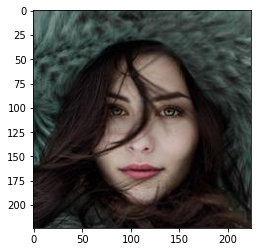

In [29]:
show_image_from_array(1.0/255*imgs[9])

In [30]:
# adjust dataset size
X = 1.0/255*imgs[:9]


In [31]:
# Model #1 test
model = Sequential()
model.add(InputLayer(input_shape=(res, res, 1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (4, 4), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.compile(optimizer='Adam', loss='mse', metrics = ['accuracy'])

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 256)     295168    
                                                                 
 conv2d_3 (Conv2D)           (None, 56, 56, 256)       590080    
                                                                 
 conv2d_4 (Conv2D)           (None, 56, 56, 256)       590080    
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 256)       590080    
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 256)       1

In [33]:
es = EarlyStopping(patience=30, restore_best_weights=True, monitor='val_loss')

In [34]:
# Train model      

model.fit(image_a_b_gen(batch_size, 'training'), steps_per_epoch = 10, validation_data = image_a_b_gen(batch_size, 'validation'), validation_steps = 5, epochs=1000, callbacks=es)

Epoch 1/1000
10/10 [==============================] - 16s 226ms/step - loss: 0.1957 - accuracy: 0.4787 - val_loss: 0.0057 - val_accuracy: 0.4026
Epoch 2/1000
10/10 [==============================] - 2s 159ms/step - loss: 0.0064 - accuracy: 0.5227 - val_loss: 0.0032 - val_accuracy: 0.7311
Epoch 3/1000
10/10 [==============================] - 2s 158ms/step - loss: 0.0060 - accuracy: 0.5818 - val_loss: 0.0035 - val_accuracy: 0.7426
Epoch 4/1000
10/10 [==============================] - 2s 161ms/step - loss: 0.0059 - accuracy: 0.5910 - val_loss: 0.0040 - val_accuracy: 0.7091
Epoch 5/1000
10/10 [==============================] - 2s 155ms/step - loss: 0.0060 - accuracy: 0.5927 - val_loss: 0.0030 - val_accuracy: 0.6425
Epoch 6/1000
10/10 [==============================] - 2s 156ms/step - loss: 0.0058 - accuracy: 0.5782 - val_loss: 0.0034 - val_accuracy: 0.6603
Epoch 7/1000
10/10 [==============================] - 2s 156ms/step - loss: 0.0054 - accuracy: 0.6168 - val_loss: 0.0026 - val_accuracy

In [35]:
# Test images
Xtest = rgb2lab(1.0/255*X[-20:])[:,:,:,0]
Xtest = Xtest.reshape(Xtest.shape+(1,))
Ytest = rgb2lab(1.0/255*X[-20:])[:,:,:,1:]
Ytest = Ytest / 128
print(model.evaluate(Xtest, Ytest, batch_size=batch_size))

1/1 [==============================] - 1s 1s/step - loss: 1.3513e-04 - accuracy: 0.4602
[0.00013513087469618767, 0.46017131209373474]


In [36]:
xtest, _ = get_X_Y(imgs[9], 224)

In [37]:
output = model.predict(xtest)

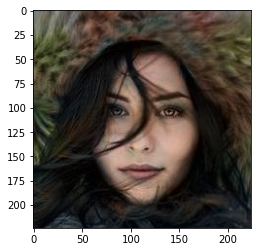

In [38]:
# not trained on this image
show_image_from_array(color_image(xtest,output,224))

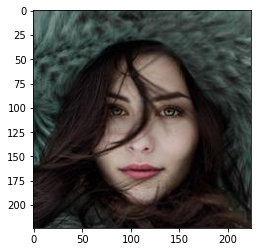

In [44]:
show_image_from_array(1.0/255*imgs[9])

In [ ]:
! mkdir result

In [47]:
color_me = []
i = 0
for filename in os.listdir(folder):
    color_me.append(img_to_array(load_img(folder+filename)))
    i += 1
    if i == 20:
      break
color_me = np.array(color_me, dtype=float)
color_me = rgb2lab(1.0/255*color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))


# Test model
output = model.predict(color_me)
output = output * 128

# Output colorizations
for i in range(len(output)):
    cur = np.zeros((224, 224, 3))
    cur[:,:,0] = color_me[i][:,:,0]
    cur[:,:,1:] = output[i]

    imsave("result/img_"+str(i)+".png", lab2rgb(cur))

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 5 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


Model 2

In [48]:
# additional parameters
batch_size = 25

In [49]:
# select dataset folder
folder = "flicker_cropped/"

In [50]:
imgs = get_images(folder)

In [51]:
imgs.shape

(7999, 224, 224, 3)

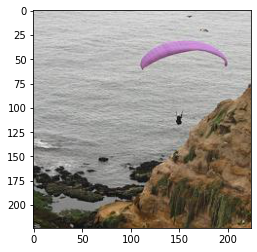

In [52]:
show_image_from_array(1.0/255*imgs[9])

In [53]:
# adjust dataset size
X = 1.0/255*imgs[:500]


In [67]:
inputs1 = Input(shape=(224, 224, 1,))
inputs2 = inputs1
inputs2 = Conv2D(3, (3, 3), activation='relu', padding='same')(inputs2)




features_model = InceptionV3(weights='imagenet', include_top=False)(inputs2)
features_output = features_model
features_output = GlobalAveragePooling2D()(features_output)




encoder_model = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(inputs1)
encoder_model = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_model)
encoder_model = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_model)
encoder_model = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_model)
encoder_model = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_model)
encoder_model = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_model)
encoder_model = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_model)
encoder_model = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_model)

concat_shape = (np.uint32(encoder_model.shape[1]), np.uint32(encoder_model.shape[2]),np.uint32(features_model.shape[-1]))


image_feature = RepeatVector(int(np.uint32(concat_shape[0])*np.uint32(concat_shape[1])))(features_output)
image_feature = Reshape(concat_shape)(image_feature)


fusion_output = concatenate([encoder_model, image_feature], axis=3)

decoder_model = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
decoder_model = UpSampling2D((2, 2))(decoder_model)
decoder_model = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_model)
decoder_model = UpSampling2D((2, 2))(decoder_model)
decoder_model = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_model)
decoder_model = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_model)
decoder_model = Conv2D(2, (3, 3), activation='relu', padding='same')(decoder_model)
decoder_model = UpSampling2D((2, 2))(decoder_model)

model2 = Model(inputs=inputs1, outputs=decoder_model)

In [68]:
model2.layers

In [69]:
for layer in model2.layers:
    # selecting layer by name
    if layer.name == 'inception_v3':
        layer.trainable = False
        print('yay')


yay


In [70]:
model2.compile(optimizer='Adam', loss='mse', metrics = ['accuracy'])

In [71]:
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_324 (Conv2D)            (None, 112, 112, 64  640         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_325 (Conv2D)            (None, 112, 112, 12  73856       ['conv2d_324[0][0]']             
                                8)                                                          

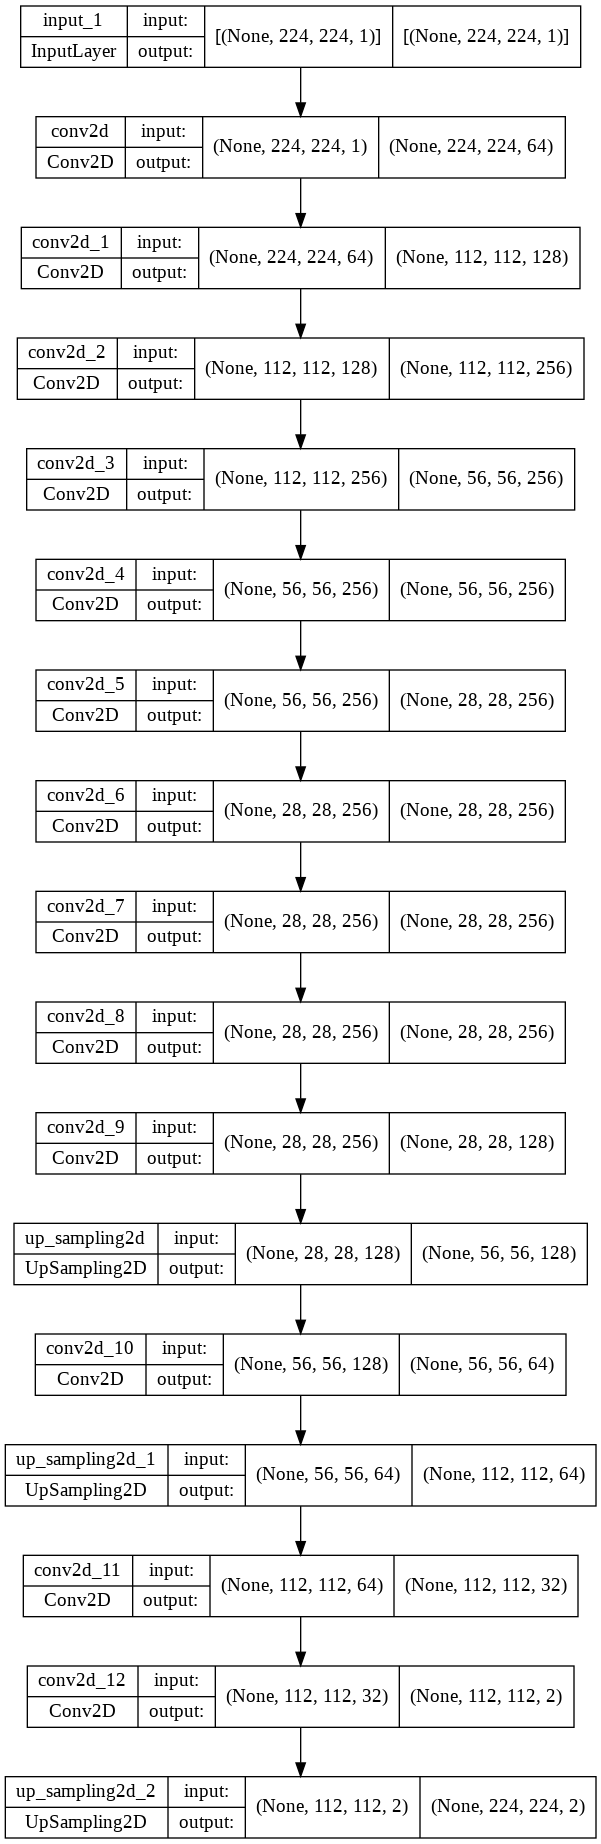

In [72]:
# not exactly sure why, but sometimes it does not show the other branch

from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)


In [73]:
es = EarlyStopping(patience=50, restore_best_weights=True, monitor='val_loss')

In [74]:
# Train model      

model2.fit(image_a_b_gen(batch_size, 'training'), steps_per_epoch = 20, validation_data = image_a_b_gen(batch_size, 'validation'), validation_steps = 10, epochs=100, callbacks=es)

Epoch 1/100
20/20 [==============================] - 27s 801ms/step - loss: 0.9343 - accuracy: 0.3915 - val_loss: 0.0129 - val_accuracy: 0.3573
Epoch 2/100
20/20 [==============================] - 14s 720ms/step - loss: 0.0140 - accuracy: 0.3799 - val_loss: 0.0129 - val_accuracy: 0.3461
Epoch 3/100
20/20 [==============================] - 14s 720ms/step - loss: 0.0138 - accuracy: 0.3857 - val_loss: 0.0125 - val_accuracy: 0.3635
Epoch 4/100
20/20 [==============================] - 14s 728ms/step - loss: 0.0146 - accuracy: 0.3685 - val_loss: 0.0130 - val_accuracy: 0.3578
Epoch 5/100
20/20 [==============================] - 14s 723ms/step - loss: 0.0138 - accuracy: 0.3774 - val_loss: 0.0129 - val_accuracy: 0.3524
Epoch 6/100
20/20 [==============================] - 14s 700ms/step - loss: 0.0140 - accuracy: 0.3772 - val_loss: 0.0126 - val_accuracy: 0.3629
Epoch 7/100
20/20 [==============================] - 16s 813ms/step - loss: 0.0146 - accuracy: 0.3734 - val_loss: 0.0130 - val_accuracy:

In [75]:
! mkdir result2

In [76]:
color_me = []
i = 0
for filename in os.listdir(folder):
    color_me.append(img_to_array(load_img(folder+filename)))
    i += 1
    if i == 20:
      break
color_me = np.array(color_me, dtype=float)
color_me = rgb2lab(1.0/255*color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))


# Test model
output = model2.predict(color_me)
output = output * 128

# Output colorizations
for i in range(len(output)):
    cur = np.zeros((224, 224, 3))
    cur[:,:,0] = color_me[i][:,:,0]
    cur[:,:,1:] = output[i]

    imsave("result2/img_"+str(i)+".png", lab2rgb(cur))

In [77]:
xtest, _ = get_X_Y(imgs[2000], 224)

In [78]:
output = model2.predict(xtest)

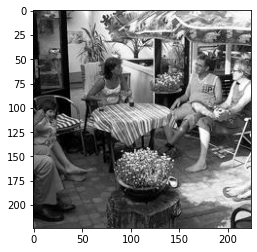

In [79]:
# not trained on this image
show_image_from_array(color_image(xtest,output,224))

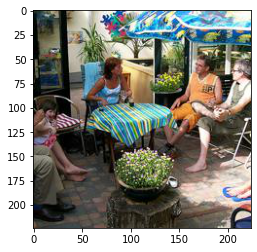

In [80]:
show_image_from_array(1.0/255*imgs[2000])